# 14.프로젝트: CIFAR-10 이미지 생성하기
##### !. Google colab pro에서 작성되었습니다.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 목차
STEP 0. 주요 라이브러리 import.  
STEP 1. 작업환경 구성하기  
STEP 2. 데이터셋 구성하기  
STEP 3. 생성자 모델 구현하기  
STEP 4. 판별자 모델 구현하기   
STEP 5. 손실함수와 최적화 함수 구현하기    
STEP 6. 훈련과정 상세 기능 구현하기  
STEP 7. 학습 과정 진행하기  
STEP 8. (optional) GAN 훈련 과정 개선하기  
회고록   
Reference

---

### (서론)

GAN을 학습하는 과정은 까다롭다.  
모델 구조, learning_rate, 파라미터 초기화, 생성자와 판별자의 경쟁 관계, 데이터의 특성 등 고려해야 할 것이 많다.  
이 프로젝트에서는 앞에서 배운 FASHION-MNIST 데이터 생성용 DCGAN 모델구조를 이용해서 CIFAR-10 데이터를 생성하는 모델을 직접 구현하고자 한다.

특이점.
* 이미지 데이터의 shape가(32, 32, 3)으로 됨.  
* 생성자, 판별자 모델의 입출력 shape및 모델 구조에 영향이 있음
* 이미지가 RGB 3채널의 컬러이미지임(시각화 과정에서 고려할 점이 있음)

---

### (본문)

### STEP 0. 주요 라이브러리 import

In [4]:
# 신경망 구성에 필요한 텐서플로우 라이브러리 설치
# 이미지와 GIF를 다루는 데 쓰이는 imageio, display, matplotlib, PIL 라이브러리 설치
import os
import glob
import time

import PIL
import imageio
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

### STEP 1. 작업환경 구성하기

* 폴더 3개 생성
 * dcgan_newimage/cifar10/generated_samples
 * dcgan_newimage/cifar10/training_checkpoints
 * dcgan_newimage/cifar10/training_history

### STEP 2. 데이터셋 구성하기

CIFAR-10 데이터셋은 tf.keras 안에 있는 datasets에 포함되어 있어서, 아래와 같이 손쉬게 데이터셋을 구성할 수 있음.

In [5]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

170508288/170498071 [==============================] - 11s 0us/step


(50000, 32, 32, 3)

꺼낸 이미지는 픽셀로 이루어져 있으며, 각 픽셀은 0~255 사이의 정숫값을 가짐.

In [6]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


학습에 사용할 train_x의 이미지를 (-1, 1)로 정규화.  
중간값을 0으로 맞춰주기 위해 127.5를 뺀 후 127.5로 나누어줌.

In [7]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화하는 코드.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


로드한 학습 데이터를 시각화를 통해 확인.

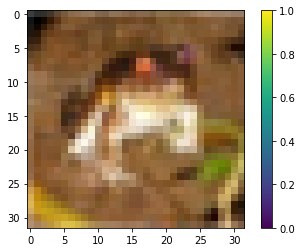

In [75]:
plt.imshow((train_x[0]+1)/2)
plt.colorbar()
plt.show()

tf.data.Dataset 모듈의 from_tensor_slices()함수를 사용하여 미니배치 데이터셋을 구성.

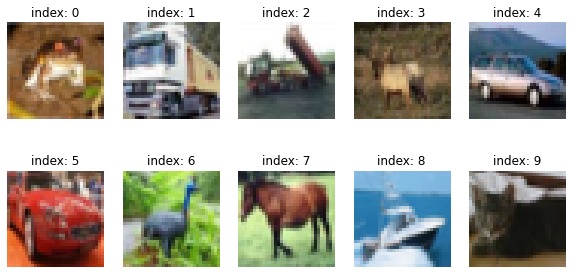

In [76]:
plt.figure(figsize=(10, 5)) #이미지 전체 프레임의 크기를 결정.
# 여러개의 이미지를 한 번에 띄우고 싶을 때에는 pl.subplot(row, col, index)의 형태로 볼 수 있음

for i in range(10): #for문을 활용하여 이미지 10개를 2X5의 배열로 띄워줌.
    plt.subplot(2, 5, i+1)
    plt.imshow((train_x[i]+1)/2)
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

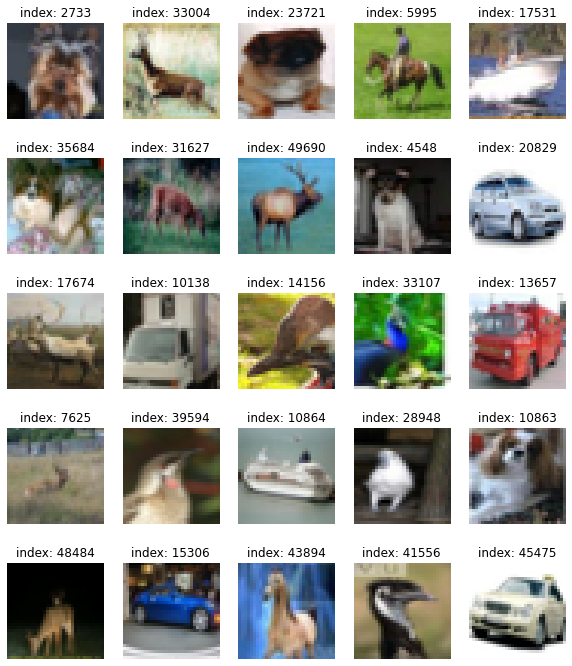

In [77]:
import random

plt.figure(figsize=(10, 12))

for i in range(25):
    plt.subplot(5, 5, i+1)
    np.random.seed(i)  # seed 로 고정된 랜덤 사용
    random_i = np.random.randint(1, len(train_x))
    plt.imshow((train_x[random_i]+1)/2)
    plt.title(f'index: {random_i}')
    plt.axis('off')

plt.show()

In [78]:
BUFFER_SIZE = 50000  # len(train_x) == 50000, 전체 데이터를 섞기 위해 50,000으로 설정, cifar은 총 6만개(트레인, 테스트 데이터)로 구성
BATCH_SIZE = 256  # 미니 배치 학습, 모델이 한 번에 학습할 데이터의 양.
# 너무 많은 양을 한 번에 학습시키면 메모리 활용 면에서도 비효율적이고, 한 번 학습을 하는 데에도 오래 걸리므로 적절한 사이즈로 잘하서 학습을 진행 -> 미니배치 학습.

In [79]:
# numpy ndarray(train_x): 자료를 섞고 배치 사이즈에 따라 나눔
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

tf.data.Dataset 모듈의 from_tensor_slices() 함수를 사용하면 리스트, 넘파이, 또는 텐서플로우의 텐서 자료형에서 데이터셋을 만들 수 있음.   
위 코드는 train_x라는 넘파이 배열(numpy ndarray)형 자료를 섞고, 이를 배치 사이즈에 따라 나누도록 함.  
데이터가 잘 섞이게 하기 위해서는 버퍼 사이즈를 총 데이터 사이즈와 같거나 크게 설정하는 것이 좋음


### STEP3. 생성자 모델 구현하기

#### GAN(Generative Adversrial Network).
* GAN은 2014년 Ian Goodfollow라는 연구자에 의해 처음 나온 네트워크.(생성 모델 중 하나.)
 * `생성자(Genetator)`는 아무 의미 없는 랜덤 노이즈로부터 신경망에서의 연산을 통해 이미지 형상의 벡터를 생성 해냄. 즉, 무에서 유를 창조하는 것과 같은 역할을 함.
 * `판별자(Discriminator)`는 기존에 있던 진짜 이미지와 생성자가 만들어낸 이미지를 입력받아 각 이미지가 Real인지, Fake인지에 대한 판단 정도를 실숫값으로 출력.

이를 설명한 논문에서는 생성자 모델을 위조지폐를 만들어내는 팀, 판별자 모델을 위조 지폐범을 잡아내는 경찰이라고 비유함.(출처: Generative Adversarial Nets)
궁극적으로 생성자 모델과 판별자 모델의 경쟁을 통해 진짜 지폐와 구분될 수 없는 위조지폐를 만들어 내는 것이라고 할 수 있음.

(32,32,3)의 shape를 가진 이미지를 생성하는 생성자 모델 구현 함수를 작성.

모델의 구현은 Keras Sequential API를 활용.    
`make_generator_model`이라는 함수를 만들어서 언제든 `생성자`를 생성할 수 있도록 함.

In [80]:
# 생성자 생성 함수
def make_generator_model():

    # Start
    # 함수 내부에서는 먼저 tf.keras.Sequential()로 모델을 시작한 후 레이어를 차곡차곡 쌓아줌.
    model = tf.keras.Sequential()

    # First: Dense layer  # 32=8*4 이므로 8
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer  # output channel 설정
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model
    # 여기에서 가장 중요한 레이어는 바로 Conv2DTranspose 레이어
    # Conv2DTranspose 층은 일반적인 Conv2D와 반대로 이미지 사이즈를 넓혀주는 층
    # 이 모델에서는 세 번의 Conv2DTranspose 층을 이용해 (8, 8, 256) → (16, 16, 64) → (32, 32, 3) 순으로 이미지를 키워나감.

레이어의 사이사이에 특정 층들이 반복되는 것을 확인할 수 있는데, BatchNormalization 레이어는 신경망의 가중치가 폭발하지 않도록 가중치 값을 정규화시켜줌.   
또한 중간층들의 활성화 함수는 모두 LeakyReLU를 사용.   
다만 마지막 층에는 활성화 함수로 tanh를 사용하는데, 이는 우리가 -1 ~ 1 이내의 값으로 픽셀 값을 정규화시켰던 데이터셋과 동일하게 하기 위함.

In [81]:
# 생성 모델을 generator라는 변수로 생성하고, 모델 세부 내용인 summary를 출력
generator = make_generator_model()

generator.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 16384)             1638400   
                                                                 
 batch_normalization_6 (Batc  (None, 16384)            65536     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 16384)             0         
                                                                 
 reshape_2 (Reshape)         (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 8, 8, 128)        819200    
 ranspose)                                                       
                                                                 
 batch_normalization_7 (Batc  (None, 8, 8, 128)       

`noise = tf.random.normal([1, 100])`로 생성된 랜덤 노이즈를 입력으로 하여 방금 구현한 생성자로 랜덤 이미지를 생성

In [85]:
#tf.random.normal을 이용하면 가우시안 분포에서 뽑아낸 랜덤 벡터로 이루어진 노이즈 벡터를 만들 수 있음
noise = tf.random.normal([1, 100])

텐서플로우 2.0 이후 버전에서는 레이어와 모델에 call 메소드를 구현해 놓기 때문에, 방금 만들어진 생성자 모델에 입력값으로 노이즈를 넣고 바로 모델을 호출하면 간단히 결과 이미지가 생성

단, 지금은 학습하는 중이 아니니 `training=False`를 설정해 주어야 함.  
 Batch Normalization 레이어는 훈련 시기와 추론(infernce) 시기의 행동이 다르기 때문에 `training=False`을 주어야 올바른 결과를 얻을 수 있음.

In [86]:
generated_image = generator(noise, training=False)
generated_image.shape  # TensorShape([1, 32, 32, 3]) # [batch_size(1), image(32,32,1)]

TensorShape([1, 32, 32, 3])

[1, 32, 32, 3] 사이즈의 이미지 생성확인.  
첫 번째 1은 1개(batch_size=1)라는 뜻을, 그 뒤로는 (32, 32, 3) 사이즈 이미지가 생성되었다는 뜻을 가짐.  

생성된 랜덤 이미지가 생성자 출력 규격에 잘 맞는지 확인

matplotlib 라이브러리는 2차원 이미지만 보여줄 수 있으므로 0번째와 3번째 축의 인덱스를 0으로 설정해서 (28, 28) shape의 이미지를 꺼낼 수 있도록 해야 함.

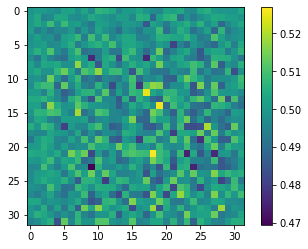

In [87]:
plt.imshow((generated_image[0, :, :, 0]+1)/2)
plt.colorbar()
plt.show()

-1과 1 사이의 값에서 적당히 잘 생성된 것을 확인할 수 있음.  
아직은 모델이 전혀 학습하지 않은 상태이기 때문에 아무런 의미가 없는 노이즈 같은 이미지가 생성되었지만, 모델이 점차 학습해 나가며 제대로 된 이미지를 생성.

### STEP 4. 판별자 모델 구현하기

판별자는 가짜 이미지와 진짜 이미지를 입력받으면 각 임지 별로 '진짜라고 판단하는 정도'값을 출력해야 함.  
입력은 (32,32,3) 크기의 이미지.  
출력은 단 하나의 숫자(진짜라고 판단하는 정도).

(32, 32, 3)의 이미지를 입력으로 받아 1dim을 판별결과를 출력하는 판별자 모델 구현 함수를 작성

판별자 또한 make_discriminator_model 함수로 구현

In [88]:
#Conv2DTranspose 층을 사용해서 이미지를 키워나갔던 생성자와 반대로, 판별자는 Conv2D 층으로 이미지의 크기를 점점 줄여나감.
#첫 번째 Conv2D 층에서 입력된 [32, 32, 3] 사이즈의 이미지는 다음 층을 거치며 (32, 32, 3) → (16, 16, 64) → (8, 8, 128)까지 줄어들게 됩
#판별자 생성 함수.
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # 마지막에는 Flatten 층을 사용해 3차원 이미지를 1차원으로 쭉 펴서 8x8x128=8192, 즉 (1, 8192) 형상의 벡터로 변환
    # 이는 생성자의 Reshape 층에서 1차원 벡터를 3차원으로 변환했던 것과 정확히 반대 역할을 함. 1차원 벡터로 변환한 후에는 마지막 Dense Layer를 거쳐 단 하나의 값을 출력
    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer  # 숫자 1개(진짜라고 판단되는 정도)
    model.add(layers.Dense(1))

    return model

위 STEP 2에서 생성한 랜덤 이미지를 판별자 모델이 판별한 결과값을 확인

판별 모델을 `discriminator`라는 변수 이름으로 생성하고, 모델 세부 내용인 summary를 출력

In [89]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 16, 16, 64)        4864      
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 16, 16, 64)        0         
                                                                 
 dropout_4 (Dropout)         (None, 16, 16, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 dropout_5 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 flatten_2 (Flatten)         (None, 8192)             

In [90]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00056447]], dtype=float32)>

텐서플로우의 텐서 형태로 출력이 되었음.   이 값 또한 아직은 아무런 의미가 없는 값

### STEP 5. 손실함수와 최적화 함수 구현하기

생성자와 판별자의 손실함수(loss)를 구현

#### 손실함수(los function)
딥러닝 모델이 학습하기 위해서 꼭 필요한 두 가지는, 바로 손실함수(loss function)와 최적화 함수(optimizer).
* 손실함수(loss function)
  * GAN은 손실함수로 교차 엔트로피(Cross Entorpy)를 사용.
  * 교차 엔트로피는 앞서 분류 모델을 설계할 때 많이 사용했던 손실함수.
  * 점점 가까워지기 원하는 두 값이 얼마나 큰 차이가 나는지를 정량적으로 계산할 때 많이 쓰임.
  * 특히 판별자는 한 개의 이미지가 가짜인지 진짜인지 나타내는 2개 클래스 간 분류 문제를 풀어야 하므로, 이진 교차 엔트로피(binary cross entorpy)를 사용.

   * 생성자 : 판별자가 Fake Image에 대해 판별한 값, 즉 D(fake_image) 값이 1에 가까워지는 것
   * 판별자 : Real Image 판별값, 즉 D(real_image)는 1에, Fake Image 판별값, 즉 D(fake_image)는 0에 가까워지는 것
   * 결국 생성자든 구분자든, 손실함수에 들어가는 값은 모두 판별자의 판별값이 됨.


손실함수에 사용할 교차 엔트로피 함수는 tf.keras.losses 라이브러리 안에 있음.  
다만, 교차 엔트로피를 계산하기 위해 입력할 값은 판별자가 판별한 값인데, 판별자 모델의 맨 마지막 Layer에는 값을 정규화시키는 sigmoid나 tanh 함수와 같은 활성화 함수가 없었음.  
구분자가 출력하는 값은 범위가 정해지지 않아 모든 실숫값을 가질 수 있음.  
tf.keras.losses의 BinaryCrossEntropy 클래스는 기본적으로 본인에게 들어오는 인풋값이 0-1 사이에 분포하는 확률값이라고 가정.  
따라서 from_logits를 True로 설정해 주어야 BinaryCrossEntropy에 입력된 값을 함수 내부에서 sigmoid 함수를 사용해 0~1 사이의 값으로 정규화한 후 알맞게 계산할 수 있음.  



In [91]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

* cross_entropy를 활용해 계산할 loss들은 fake_output와 real_output, 두 가지를 활용.

 * fake_output : 생성자가 생성한 Fake Image를 구분자에 입력시켜서 판별된 값, 즉 D(fake_image)
 * real_output : 기존에 있던 Real Image를 구분자에 입력시켜서 판별된 값, 즉 D(real_image)


fake_output과 real_output을 각각 1 또는 0에 비교를 하기위해 tf.ones_like()와 tf.zeros_like() 함수를 활용하면 됨.  
이 함수들은 특정 벡터와 동일한 크기이면서 값은 1 또는 0으로 가득 채워진 벡터를 만들고 싶을 때 사용.  

#### generator_loss

`generator_loss`는 `fake_output`가 1에 가까워지기를 바라므로, 다음과 같이 `tf.ones_like`와의 교차 엔트로피값을 계산하면 됨.

즉, `cross_entropy(tf.ones_like(fake_output), fake_output)` 값은 fake_output이 (Real Image를 의미하는) 1에 가까울수록 작은 값을 가짐.

In [92]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

#### discriminator_loss

판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 정확도(accuracy)를 계산하는 함수를 구현.  
`discriminator_loss`는 `real_output` 값은 1에 가까워지기를, `fake_output` 값은 0에 가까워지기를 바라므로, 두 가지 loss값을 모두 계산합니다. `real_output`은 1로 채워진 벡터와, `fake_output`은 0으로 채워진 벡터와 비교하면 됨.  
최종 discriminator_loss 값은 이 둘을 더한 값.

In [93]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

#### discriminator accuracy

판별자가 real output, fake output을 얼마나 정확히 판별하는지의 accuracy를 계산해 보는 것도 GAN의 학습에서 매우 중요.  
특히 두 accuracy를 따로 계산해서 비교해 보는 것이 매우 유용.  

[참고]
만약 판별자가 real output과 fake output을 accuracy가 1.0에 가까울 정도로 정확하게 판별해 낸다면 좋은 것이 아님. 이 경우 생성자가 만들어내는 fake output이 real output과 차이가 많이 나기 때문에 판별자가 매우 쉽게 판별해 내고 있다는 뜻. 그래서, real accuracy와 fake accuracy는 초반에는 1.0에 가깝게 나오다가, 서서히 낮아져서 둘 다 0.5에 가까워지는 것이 이상적. fake accuracy가 1.0에 더 가깝다면 아직은 생성자가 판별자를 충분히 잘 속이지 못하고 있다는 뜻

In [94]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

위 함수 안에 사용된 tensorflow 함수들의 역할을 순차적으로 예를 들어 정리하면 다음과 같음.

ex.) real_output = tf.Tensor([0.2, 0.4, 0.7, 0.9]) 라면,

(1) tf.math.greater_equal(real_output, tf.constant([0.5]) : real_output의 각 원소가 0.5 이상인지 True, False로 판별
>> tf.Tensor([False, False, True, True])
(2) tf.cast( (1), tf.float32) : (1)의 결과가 True이면 1.0, False이면 0.0으로 변환
>> tf.Tensor([0.0, 0.0, 1.0, 1.0])
(3) tf.reduce_mean( (2)) : (2)의 결과를 평균내어 이번 배치의 정확도(accuracy)를 계산
>> 0.5

#### 최적화 함수(optimizer)

생성자와 판별자를 최적화하는 optimizer를 정의(Adam 최적화 기법을 활용).  
Adam 함수 또한 tf.keras.optimizers 안에 있음.  
중요한 하이퍼 파라미터인 "learning rate"는 0.0001로 설정할 텐데, 학습 품질을 올려보고 싶다면 여러 가지로 값을 바꾸어 가며 학습을 진행해 보는 것을 추천.  

[중요]
생성자와 구분자는 따로따로 학습을 진행하는 개별 네트워크이기 때문에 optimizer를 따로 만들어주어야 함.

In [95]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

매 번 학습이 어떻게 진행되어가고 있는지를 확인하기 위해 생성자가 생성한 샘플을 확인.

샘플은 한 번에 16장을 생성.  
생성할 샘플은 매번 같은 노이즈로 생성해야 그에 대한 진전 과정을 확인할 수 있으므로, 고정된 seed 노이즈를 만들어두어야 함.  
100차원의 노이즈를 총 16개, (16, 100) 형상의 벡터를 만들어 둠.

In [96]:
noise_dim = 100  # 100차원
num_examples_to_generate = 16  # 샘플 16개

seed = tf.random.normal([num_examples_to_generate, noise_dim])  # 고정된 seed 노이즈
seed.shape  # (16,100) 벡터

TensorShape([16, 100])

### STEP 6. 훈련과정 상세 기능 구현하기

1개 미니배치의 훈련 과정을 처리하는 `train_step()` 함수를 구현.  
텐서플로우 2.0 이후부터는 1.x의 이전 버전과 다르게, session을 사용하지 않음. 대신, 학습시킬 훈련 함수 위에 `@tf.function` 이라는 데코레이터를 붙여서 사용합니다. 이 데코레이터는 우리가 직접 session을 열어서 학습했다가, 학습이 완료되면 다시 닫아주는 등의 번거로운 과정을 내부적으로 처리해서 더욱 편리하게 학습시킬 수 있게 해줌.

In [97]:
@tf.function
def train_step(images):  #(1) 입력데이터: Real Image 역할을 할 images 한 세트를 입력으로 받음
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈: generator가 FAKE IMAGE를 생성하기 위한 noise를 images 한 세트와 같은 크기인 BATCH_SIZE 만큼 생성함

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈: 가중치 갱신을 위한 Gradient를 자동 미분으로 계산하기 위해 with 구문 열기
        generated_images = generator(noise, training=True)  #(4) generated_images 생성:  generator가 noise를 입력받은 후 generated_images 생성

        #(5) discriminator 판별: discriminator가 Real Image인 images와 Fake Image인 generated_images를 각각 입력받은 후 real_output, fake_output 출력
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산: fake_output, real_output으로 generator와 discriminator 각각의 loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산: fake_output, real_output으로 discriminator의 정확도 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산: gen_tape와 disc_tape를 활용해 gradient를 자동으로 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습: 계산된 gradient를 optimizer에 입력해 가중치 갱신
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값: 이번 스텝에 계산된 loss와 accuracy를 리턴
    # 이 과정을 통해 한 번의 train_step이 끝나게 됨.

16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 `generate_and_save_images()` 함수를 구현

In [98]:
def generate_and_save_images(model, epoch, it, sample_seeds, save_file_num=1):

    predictions = model(sample_seeds, training=False)  # 16개의 seed 가 들어있는 sample_seeds
    
    # [-1,1]로 정규화된 이미지를 원상복구함
    rescue_predictions = (predictions.numpy() * 127.5 + 127.5).astype(int)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)  # 16개 sample 이라서 4행 4열로 시각화
        plt.imshow(rescue_predictions[i])  # plt.imshow(np.array(predictions[i, :, :, :]*127.5 + 127.5).astype('uint8'))
        plt.axis('off')
   
    plt.tight_layout()  # subplot 간격 자동 조절(겹치지 않게)

    save_file_path = '/content/drive/MyDrive/Colab_Notebooks/E_14_GAN/dcgan_newimage/cifar10/generated_samples/sample_{}'.format(save_file_num)
    if not os.path.exists(save_file_path):
        os.makedirs(save_file_path)
    
    save_file_path = os.path.join(save_file_path, 'sample_epoch_{:04d}_iter_{:03d}.png'.format(epoch, it))
    plt.savefig(save_file_path)  # 이미지 저장

    plt.show()

훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화하는 `draw_train_history()` 함수를 구현

학습 과정을 체크하기 위해 시각화해 보아야 할 중요한 것으로 loss와 accuracy 그래프를 빼놓을 수 없음.   
GAN의 학습 과정은 지도학습 모델보다 까다로운데, 이것은 두 모델이 서로의 학습 과정에 영향을 주고받기 때문.
train_step() 함수가 리턴하는 gen_loss, disc_loss, real_accuracy, fake_accuracy 이상 4가지 값을 history라는 dict 구조에 리스트로 저장하고 있다가 매 epoch마다 시각화하는 함수를 만듬.   
생성자의 loss의 history는 history['gen_loss']로 접근할 수 있는 list로 관리할 예정  

In [100]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정

def draw_train_history(history, epoch, save_file_num=1):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')

    plt.tight_layout()  # subplot 간격 자동 조절(겹치지 않게)
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장
    save_file_path = '/content/drive/MyDrive/Colab_Notebooks/E_14_GAN/dcgan_newimage/cifar10/training_history/train_history_{}'.format(save_file_num)
    if not os.path.exists(save_file_path):
        os.makedirs(save_file_path)
    
    save_file_path = os.path.join(save_file_path, 'train_history_{:04d}.png'.format(epoch))
    plt.savefig(save_file_path)  # 이미지 저장

    plt.show()

`training_checkpoints` 디렉토리에 몇 epoch마다(정기적으로) 모델을 저장하는 checkpoint 모듈을 설정.  
checkpoint에는 optimizer와 생성자, 판별자를 모두 넣어 저장함.  
 정확히는 생성자와 판별자가 학습한 모델 가중치를 저장하는 것.  
게임의 체크포인트처럼 우리의 학습 환경과 학습한 내용을 저장해 둠.

In [101]:
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### STEP 7. 학습 과정 진행하기

지금까지 한 단계를 학습하는 train_step, 샘플 이미지를 생성하고 저장하기 위한 `generate_and_save_images()`, 학습 과정을 시각화하는 `draw_train_history()`, 그리고 모델까지 저장하기 위한 `checkpoint`까지 모두 준비가 되었으니 이것들을 한곳에 합치기만 하면 됨.

위 STEP에서 구현한 기능들을 활용하여 최소 50 epoch만큼의 모델 학습을 진행

In [102]:
def train(dataset, epochs, save_every, save_file_num=1):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed, save_file_num)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint_dir = '/content/drive/MyDrive/Colab_Notebooks/E_14_GAN/dcgan_newimage/cifar10/training_checkpoints/training_checkpoints_{}'.format(save_file_num)
            checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed, save_file_num)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch, save_file_num)

본 학습은 이미지를 활용한 것이기 때문에 CPU 환경에서는 매우 느릴 수 있음.
RTX2070 또는 구글 Colab의 T4 정도 사양의 경우 1 Epoch 당 10초가 걸리는 반면, 일반적인 CPU 환경에서는 최소 3분에서 10분 이상이 걸릴 수 있으므로 최대한 GPU 환경에서 실습해 보는 것을 추천.

In [103]:
save_every = 5  # 모델 저장 간격 담당.
EPOCHS = 50  # 전체 학습 에포크(학습 횟수)를 결정하는 파라미터.

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#### GAN 학습 시작.

학습 과정에서 생성된 샘플 이미지로 만든 gif 파일을 통해 학습 진행 과정을 시각적으로 표현

train() 함수를 실행시키면 모델이 학습해 나가면서 만들어내는 결과물을 실시간으로 확인.(장시간 소요.)

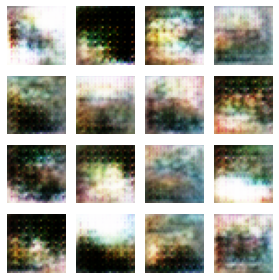

Time for training : 475 sec


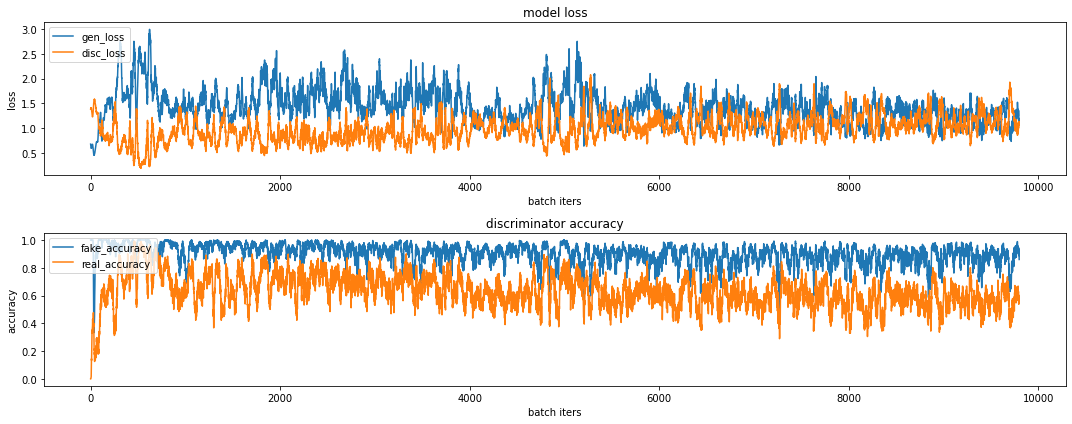

CPU times: user 8min 18s, sys: 1min 10s, total: 9min 28s
Wall time: 7min 56s


In [104]:
%%time
train(train_dataset, EPOCHS, save_every, 1)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 dcgan_newimage/cifar10/training_history 경로에 생성되고 있음
# 진행 과정을 수시로 확인할 것.

생성자가 만든 Fake Image에 대한 판별자의 Accuracy(fake_accuracy)가 계속 1에 가깝게 유지되고 있다면, 생성자가 만든 이미지가 아직 판별자를 성공적으로 속이지 못하고 있다는 뜻.

보다 나은 결과물을 만들기 위해서는 더욱 많은 epoch으로 학습을 시켜야 함.  
 결과물이 아직 흐릿하다면 더욱 많은 학습을 시켜보기.

#### 학습과정 시각화하기

학습 과정을 담은 샘플 이미지, gif 파일, 학습 진행 그래프 이미지를 함께 제출

* `imageio` : GIF 파일은 우리가 오래전에 import 해놓았던 imageio 라이브러리를 활용해 제작.  
* `imageio.get_writer`를 활용해서 파일을 열고, 거기에 `append_data`로 이미지를 하나씩 붙여나가는 방식
* 아래 코드 실행시, `fasion_mnist_dcgan.gif` 파일이 저장되어 있는 것을 확인할 수 있음.

In [108]:
def make_a_gif(anim_file_num=1, flag=True):
    if flag:
        anim_file = '/content/drive/MyDrive/Colab_Notebooks/E_14_GAN/dcgan_newimage/cifar10/gif/cifar10_dcgan_{}.gif'.format(anim_file_num)
        filenames = glob.glob('/content/drive/MyDrive/Colab_Notebooks/E_14_GAN/dcgan_newimage/cifar10/generated_samples/sample_{}/sample*.png'.format(anim_file_num))  # Fake Images
    else:
        anim_file = '/content/drive/MyDrive/Colab_Notebooks/E_14_GAN/dcgan_newimage/cifar10/gif/cifar10_dcgan_history_{}.gif'.format(anim_file_num)
        filenames = glob.glob('/content/drive/MyDrive/Colab_Notebooks/E_14_GAN/dcgan_newimage/cifar10/training_history/train_history_{}/train_history*.png'.format(anim_file_num))  # Graphs

    with imageio.get_writer(anim_file, mode='I') as writer:
        filenames = sorted(filenames)
        last = -1
        for i, filename in enumerate(filenames):
            frame = 2*(i**0.5)
            if round(frame) > round(last):
                last = frame
            else:
                continue
            image = imageio.imread(filename)
            writer.append_data(image)
        image = imageio.imread(filename)
        writer.append_data(image)

In [109]:
# Fake Images to GIF
make_a_gif(1, True)

In [110]:
# History Graphs to GIF
make_a_gif(1, False)

#### [참고] checkpoint
학습 과정 중 학습 epoch를 추가 진행해야 하거나, 학습한 모델을 활용하여 이미지를 생성할 필요가 생김.  
그럴 때마다 모델 학습을 처음부터 다시 진행한다면 시간 낭비가 될 것.  
위에서 checkpoint 모듈을 이용해 모델을 저장해 둔 것을 이용해 학습해 둔 모델을 로드하면 모델 재학습이 필요 없이 이런 작업을 진행.  
아래는 checkpoint 모듈을 활용하여 모델을 로드하는 코드.

In [111]:
def draw_training_checkpoints_image(save_file_num=1):
    checkpoint_dir = '/content/drive/MyDrive/Colab_Notebooks/E_14_GAN/dcgan_newimage/cifar10/training_checkpoints/training_checkpoints_{}'.format(save_file_num)
    latest = tf.train.latest_checkpoint(checkpoint_dir)
    checkpoint.restore(latest)

    generator = checkpoint.generator
    discriminator = checkpoint.discriminator

    # 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봄. 
    noise = tf.random.normal([1, 100])
    generated_image = generator(noise, training=False)

    np_generated = generated_image.numpy()
    np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
    np_generated = np_generated.astype(int)
    plt.imshow(np_generated[0])
    plt.tight_layout()  # subplot 간격 자동 조절(겹치지 않게)
    plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것.

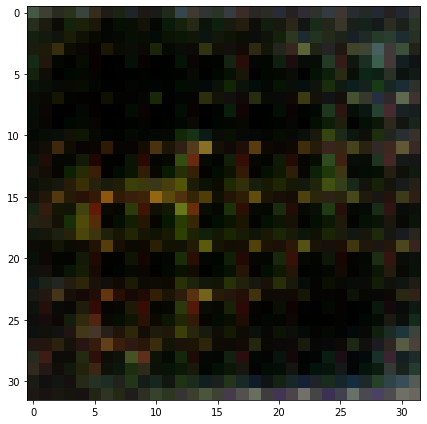

In [112]:
draw_training_checkpoints_image(1)

### STEP 8. (optional) GAN 훈련 과정 개선하기

STEP 들을 진행하면서 생성된 샘플 이미지, 학습 과정 그래프 등을 통해 이전 훈련 과정의 문제점을 분석

모델구조 또는 학습 과정을 개선한 내역과 그 결과(샘플 이미지, 학습 과정 그래프 포함)를 함께 제출

(참고사이트)
https://github.com/soumith/ganhacks  
https://towardsdatascience.com/10-lessons-i-learned-training-generative-adversarial-networks-gans-for-a-year-c9071159628   
https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/  
https://proceedings.neurips.cc/paper/2016/file/8a3363abe792db2d8761d6403605aeb7-Paper.pdf


#### 문제 분석
* 문제
 * fake image가 어떠한 형체처럼 보이지 않음.  
* 해결
 * 학습횟수(epoch) 증가
 * 하이퍼 파라미터 변경.


#### 개선안. 1. 학습횟수(epoch) 증가.
학습 횟수를 (epoch) 500 으로 변경해서 실행.  
checkpoint를 사용해서 이미지 생성

In [113]:
save_every = 5  # 모델 저장 간격
EPOCHS = 500  # 학습 횟수

In [114]:
# 체크 포인트 복구
checkpoint_dir = '/content/drive/MyDrive/Colab_Notebooks/E_14_GAN/cifar10/training_checkpints/training_checkpoints_1'
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

generator = checkpoint.generator
discriminator = checkpoint.discriminator

checkpoint를 통해 모델이 로드되었으면 아래 코드를 실행할 경우 로드된 모델의 파라미터 상태에서 훈련을 재개할 수 있음.

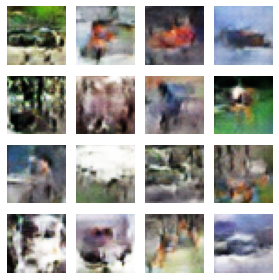

Time for training : 5414 sec


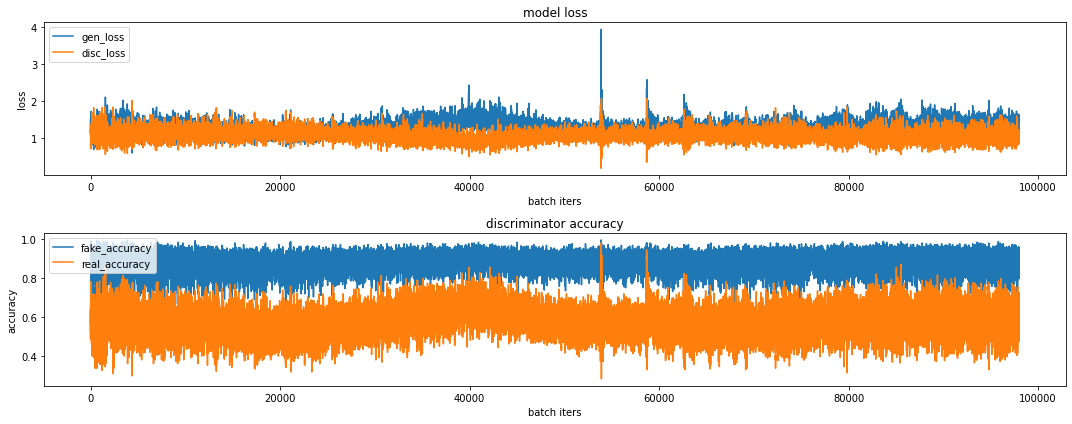

CPU times: user 1h 34min 13s, sys: 11min 51s, total: 1h 46min 4s
Wall time: 1h 30min 19s


In [115]:
%%time
train(train_dataset, EPOCHS, save_every, 2)

In [116]:
# Fake Images to GIF
make_a_gif(2, True)

In [117]:
# History Graphs to GIF
make_a_gif(2, False)


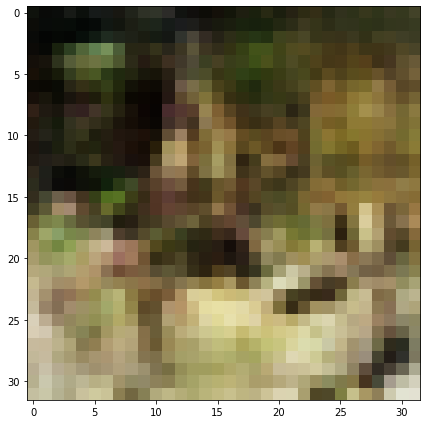

In [118]:
draw_training_checkpoints_image(2)

#### 개선안 1. 결론.
색깔이 더욱 다양해지고 살짝 선명해진 것을 확인.

#### 개선안 2. 하이퍼 파라미터 변경.


* 체크포인트 복구 없이 이미지 생성
* batch_size = 128
 * 주의: batch_size 값을 변경했기 때문에 관련 * 변수, 함수를 다시 선언해줘야 오류가 발생하지 않음!!
* epochs = 500
* optimizer: Adam
  * cifar 10 에서 AMSgrad 가 효과적이라는 말이 있어서 사용 [참고](https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/)  
  * learning_rate = 0.0002 => 2e-4
  * beta_1 = 0.5
LR = 2e-4  # learning_rate
BETA_1=0.5

generator_optimizer = tf.keras.optimizers.Adam(LR, BETA_1, amsgrad=True)  
discriminator_optimizer = tf.keras.optimizers.Adam(LR, BETA_1, amsgrad=True)  

* 레이어 관련 설정 [참고1](https://towardsdatascience.com/dcgans-generating-dog-images-with-tensorflow-and-keras-fb51a1071432) [참고2](https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/)
  * Generator Model
   * Conv2DTranspose layer 층 3개 -> 5개로 증설
   * g_kernel_size = 4
   * g_LeakyReLU_alpha = 0.2 
  * Discriminator Model
   * Conv2D layer 총 2개 -> 4개로 증설
   * d_kernel_size = 3
   * d_LeakyReLU_alpha = 0.2
   * d_dropout_rate = 0.5
   * 마지막 Dense layer 에서 활성화 함수 sigmoid 적용
model.add(layers.Dense(1, activation='sigmoid'))

In [5]:
cifar10 = tf.keras.datasets.cifar10
(train_x, _), (test_x, _) = cifar10.load_data()

train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화.

170508288/170498071 [==============================] - 3s 0us/step


In [120]:
BUFFER_SIZE = 50000  # len(train_x) == 50000
BATCH_SIZE = 128  # 미니 배치 학습

In [121]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [122]:
# 생성자 생성 함수
def make_generator_model():

    g_kernel_size = 4
    g_LeakyReLU_alpha = 0.2

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer  # 32=8*4 이므로 8
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=g_LeakyReLU_alpha))

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(512, kernel_size=(g_kernel_size, g_kernel_size), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=g_LeakyReLU_alpha))

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(256, kernel_size=(g_kernel_size, g_kernel_size), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=g_LeakyReLU_alpha))

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(g_kernel_size, g_kernel_size), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=g_LeakyReLU_alpha))

    # Sixth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(g_kernel_size, g_kernel_size), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=g_LeakyReLU_alpha))

    # Seventh: Conv2DTranspose layer  # output channel 설정
    model.add(layers.Conv2D(3, kernel_size=(g_kernel_size, g_kernel_size), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

In [123]:
generator = make_generator_model()
generator.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 16384)             1638400   
                                                                 
 batch_normalization_9 (Batc  (None, 16384)            65536     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 16384)             0         
                                                                 
 reshape_3 (Reshape)         (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_9 (Conv2DT  (None, 8, 8, 512)        2097152   
 ranspose)                                                       
                                                                 
 batch_normalization_10 (Bat  (None, 8, 8, 512)       

In [124]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

In [125]:
def make_discriminator_model():

    d_kernel_size = 3
    d_LeakyReLU_alpha = 0.2
    d_dropout_rate = 0.5

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (d_kernel_size, d_kernel_size), strides=(1, 1), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(alpha=d_LeakyReLU_alpha))
    model.add(layers.Dropout(d_dropout_rate))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (d_kernel_size, d_kernel_size), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=d_LeakyReLU_alpha))
    model.add(layers.Dropout(d_dropout_rate))

    # Third: Conv2D Layer
    model.add(layers.Conv2D(128, (d_kernel_size, d_kernel_size), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=d_LeakyReLU_alpha))
    model.add(layers.Dropout(d_dropout_rate))

    # Fourth: Conv2D Layer
    model.add(layers.Conv2D(256, (d_kernel_size, d_kernel_size), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=d_LeakyReLU_alpha))
    model.add(layers.Dropout(d_dropout_rate))

    # FIfth: Flatten Layer
    model.add(layers.Flatten())

    # sixth: Dense Layer  # 숫자 1개(진짜라고 판단되는 정도)
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

In [126]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu_20 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 dropout_6 (Dropout)         (None, 32, 32, 64)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_21 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 dropout_7 (Dropout)         (None, 16, 16, 128)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 8, 8, 128)        

In [127]:
decision = discriminator(generated_image, training=False)

In [128]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [129]:
LR = 2e-4  # learning_rate
BETA_1=0.5

generator_optimizer = tf.keras.optimizers.Adam(LR, BETA_1, amsgrad=True)
discriminator_optimizer = tf.keras.optimizers.Adam(LR, BETA_1, amsgrad=True)

In [130]:
noise_dim = 100  # 100차원
num_examples_to_generate = 16  # 샘플 16개

seed = tf.random.normal([num_examples_to_generate, noise_dim])  # 고정된 seed 노이즈
seed.shape  # (16,100) 벡터

TensorShape([16, 100])

In [131]:
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [132]:

@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [133]:
save_every = 5  # 모델 저장 간격
EPOCHS = 500  # 학습 횟수

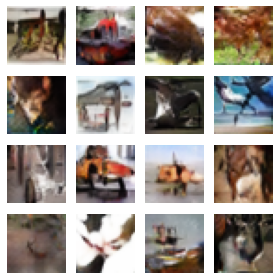

Time for training : 23885 sec


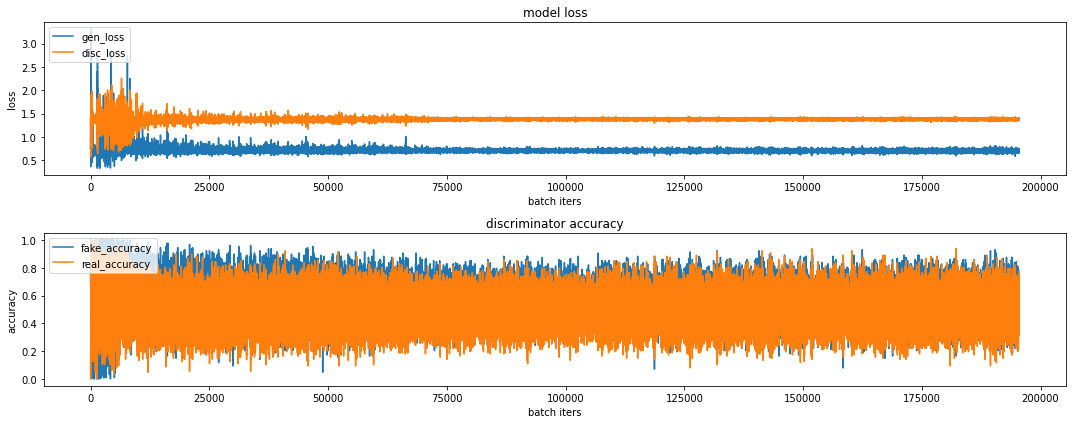

In [134]:
train(train_dataset, EPOCHS, save_every, 3)

In [135]:
# Fake Images to GIF
make_a_gif(3, True)

In [136]:
# History Graphs to GIF
make_a_gif(3, False)

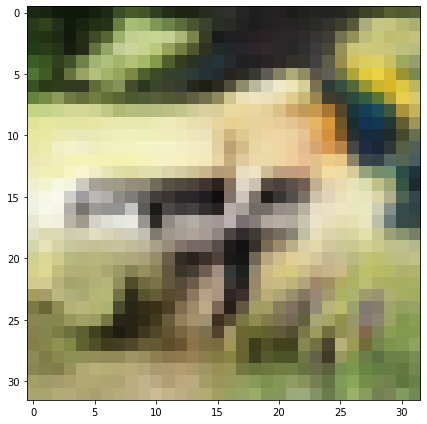

In [137]:
draw_training_checkpoints_image(3)

#### 개선안 2. 결론.

생성된 이미지가 더 밝아지고 선명해진 느낌

#### 최종결론.

|-|Total Learning Time|Setting|
|:---:|:---:|---|
|**LMS 결과**|20m 이하|default|
|**개선안 1**|2H 이상|checkpoint 불러오기, epoch=500|
|**개선안 2**|5h 이상|checkpoint 불러오기X, epoch=500, batch_size=128, optimizer.Adam(learning_rate=2e-4, beta_1=0.5, amsgrad=True), Generator Model(Conv2DTranspose layer 5개, g_kernel_size=4, g_LeakyReLU_alpha=0.2), Discriminator Model(Conv2D layer 4개, d_kernel_size=3, d_LeakyReLU_alpha=0.2, d_dropout_rate=0.5, 마지막 Dense layer에 activation='sigmoid' 적용)|

|-|LMS 결과|개선1|개선2|
|:---:|:---:|:---:|:---:|
|**Image PNG**|![](dcgan_newimage/cifar10/generated_samples/sample_1/sample_epoch_0050_iter_195.png)|![](dcgan_newimage/cifar10/generated_samples/sample_2/sample_epoch_0500_iter_195.png)|![](dcgan_newimage/cifar10/generated_samples/sample_3/sample_epoch_0500_iter_390.png)|
|**Image GIF**|![](dcgan_newimage/cifar10/gif/cifar10_dcgan_1.gif)|![](dcgan_newimage/cifar10/gif/cifar10_dcgan_2.gif)|![](dcgan_newimage/cifar10/gif/cifar10_dcgan_3.gif)|
|**History PNG**|![](dcgan_newimage/cifar10/training_history/train_history_1/train_history_0049.png)|![](dcgan_newimage/cifar10/training_history/train_history_2/train_history_0499.png)|![](dcgan_newimage/cifar10/training_history/train_history_3/train_history_0499.png)|
|**History GIF**|![](dcgan_newimage/cifar10/gif/cifar10_dcgan_history_1.gif)|![](dcgan_newimage/cifar10/gif/cifar10_dcgan_history_2.gif)|![](dcgan_newimage/cifar10/gif/cifar10_dcgan_history_3.gif)|

* Checkpoint를 활용 하는 것보다 새로 학습을 진행해 (전제. epoch를 증가시키고)이 더욱 효율적임.  
* 레이어 쌓기(특징을 얼마나 잡아낼 것인지) 파라미터 값 변경(잡아낸 특징을 어떤 비율로 처리할 것인가)중에서 이번 프로젝트에서 효과를 보인 것은 레이어 쌓기였음.  


---

### 루브릭.

|평가문항|비고|상세기준|비고 |
|:---|:---:|:---|---:|
|GAN의 두 모델 구조를 통해 이미지를 성공적으로 생성하였다.| |오브젝트 종류를 육안으로 구별할 수 있을 만한 이미지를 생성하였다. | |
|생성 이미지 시각화 및 학습 그래프를 통해 GAN 학습이 바르게 진행되었음을 입증하였다. | |gif를 통해 생성이미지 품질이 서서히 향상되는 것과, fake accuracy가 추세적으로 0.5를 향해 하향하고 있음을 확인하였다. | |
|추가적인 GAN 모델구조 혹은 학습과정 개선 아이디어를 제안하고 이를 적용하였다. | |제출 아이디어를 제출 프로젝트에 반영하고, 그 결과가 아이디어 적용 이전보다 향상되었음을 시각적으로 입증하였다. | |

---

### 회고록.

생성 모델링 개념을 이해하며 판별 모델링과의 차이를 알아 Pix2Pix, CycleGAN 등의 이미지 관련 다양한 생성 모델링의 응용을 이해해 Fashion MNIST 데이터셋의 의미와 생성적 적대 신경망(GAN)의 구조와 원리, 텐서플로우로 짠 DCGAN 학습 코드를 익히며 응용하여 학습한 데이터 셋과 Generator와 Discriminater를 활용하여 비슷하면서도 기존에는 없던 새로운 데이터셋을 생성해보는 모델을 구현해보는 14번째 Exp 프로젝트였다.  
cifar-10이라는 이미 적절하게 수집된 이미지 데이터를 활용해서 진행했으나 수치와 달리 이미지에 해당하는 결과가 그리 선명하지 않게 나와 실망스러웠다.   
이를 개선하기 위해 epoch를 높이고, 하이퍼 파라미터들을 조정하여 최소한 어떠한 형태를 가진 것 같은 무언가의 가짜 이미지를 얻어낼 수 있었다.  
fake accuracy가 미세하지만 0.5를 향해 하향하는 것도 확인할 수 있었다.  
개선안 1과 개선안 2의 차이점을 보며면서 각 파라미터 값들이 결과물에 어떠한 영향을 미치는지도 알 수 있었다.
나중에 해상도를 더 높이고 데이터셋을 더 적절하게 만들 수 있다면 완전히 새로운 이미지를 만들어낼 수 있을 것 같아 기대된다.  


현재 GAN은 이미지 처리에 있어서 많이 활용되고 있는 라이브러리인데 이를 확실하게 이해하고 넘어가기 위해서 노력할 필요가 있음. DCGAN, BigBiGAN, styleGAN처럼 좀 더 좋은 결과를 뽑아낼 수 있는 모델들을 활용할 수 있도록 할 필요가 있음.


----

### Reference. (APA)

Image-to-Image Translation with Conditional Adversarial Networks.(2022).(https://arxiv.org/pdf/1611.07004.pdf)

Generative Adversarial Nets.(2022).
(https://arxiv.org/pdf/1406.2661.pdf)

Generative Models
.(2022).(https://openai.com/blog/generative-models/)  
심층 합성곱 생성적 적대 신경망.(2022).(https://www.tensorflow.org/tutorials/generative/dcgan?hl=ko)  

What is Transposed Convolutional Layer?.(2022).https://towardsdatascience.com/what-is-transposed-convolutional-layer-40e5e6e31c11

[Deep Learning] Batch Normalization (배치 정규화).(2022).(https://eehoeskrap.tistory.com/430).  
활성화 함수(activation function).(2022).(https://newly0513.tistory.com/20)  
문과생도 이해하는 딥러닝(8) - 신경망 학습 최적화.
(2022).(https://sacko.tistory.com/42).

파이썬 - 데코레이터(Decorator).(2022).(https://schoolofweb.net/blog/posts/%ED%8C%8C%EC%9D%B4%EC%8D%AC-%EB%8D%B0%EC%BD%94%EB%A0%88%EC%9D%B4%ED%84%B0-decorator/)

-----